In [14]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [18]:
import tensorflow as tf

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [1104]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/feature_extract_reshaped.npy')
data.shape

data already loaded in parent notebook


(13237, 30, 63)

In [1215]:
data.shape

(13237, 30, 63)

In [1242]:
import numpy as np

def split_data(data, test_size=0.2, val_size=0.2, random_state=None):
    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [1243]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape)
print(f'test shape', X_test.shape)

train shape (10664, 30, 62)
test shape (2666, 30, 62)


In [1244]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [1245]:
class_weight_dict

{0.0: 0.5733333333333334, 1.0: 3.909090909090909}

In [1246]:
N_TRAIN = len(X_train)
EPOCHS = 300
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [1267]:
STEPS_PER_EPOCH

106

In [1256]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
#learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.01,
    staircase=False)


optimizer = Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [1248]:
y_train.shape

(10664,)

In [1257]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=BATCH_SIZE, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=EPOCHS,
                    validation_split = 0.2)

Epoch 1/300
107/107 [==============================] - 29s 27ms/step - loss: 1.7502 - accuracy: 0.4720
Epoch 2/300
107/107 [==============================] - 4s 32ms/step - loss: 1.5648 - accuracy: 0.4813
Epoch 3/300
107/107 [==============================] - 3s 27ms/step - loss: 1.4116 - accuracy: 0.4867
Epoch 4/300
107/107 [==============================] - 3s 26ms/step - loss: 1.2859 - accuracy: 0.5002
Epoch 5/300
107/107 [==============================] - 3s 27ms/step - loss: 1.1758 - accuracy: 0.5038
Epoch 6/300
107/107 [==============================] - 3s 25ms/step - loss: 1.0895 - accuracy: 0.5125
Epoch 7/300
107/107 [==============================] - 3s 30ms/step - loss: 1.0207 - accuracy: 0.5237
Epoch 8/300
107/107 [==============================] - 3s 25ms/step - loss: 0.9551 - accuracy: 0.5358
Epoch 9/300
107/107 [==============================] - 3s 26ms/step - loss: 0.9060 - accuracy: 0.5395
Epoch 10/300
107/107 [==============================] - 3s 28ms/step - loss: 0.86

In [1258]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    #plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

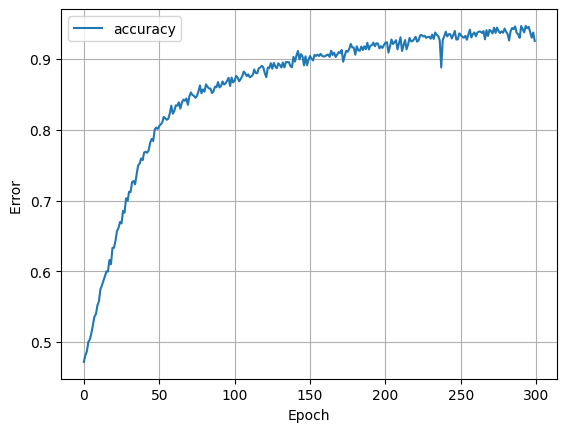

In [1268]:
plot_accuracy(history)

In [1260]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

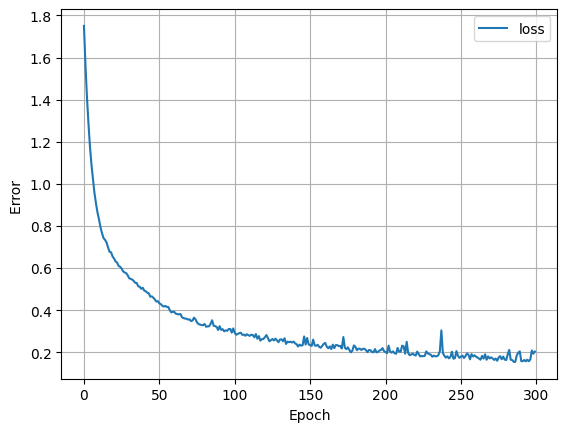

In [1269]:
plot_loss(history)

In [1184]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[1.378798246383667, 0.7708176970481873]

In [1262]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 2s - loss: 0.7826 - accuracy: 0.8605 - 2s/epoch - 22ms/step
Model accuracy: 0.8604651093482971


In [1156]:
y_pred_train = model.predict(X_train)
y_pred_train

331/331 [==============================] - 3s 6ms/step


array([[4.1310627e-06],
       [7.2449720e-06],
       [1.9813897e-06],
       ...,
       [2.7711398e-04],
       [4.9464946e-04],
       [8.6506407e-05]], dtype=float32)

In [36]:
# plt.figure(figsize=(15,10))  # Adjust the width and height as needed
# plt.plot(y_pred_train[:200])
# plt.plot(y_train[:200])


In [1270]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

84/84 [==============================] - 1s 7ms/step


(2666, 1)

In [38]:
# plt.figure(figsize=(15,10))  
# plt.plot(y_pred[:200])
# plt.plot(y_test[:200])

In [1271]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 1s 6ms/step - loss: 0.7826 - accuracy: 0.8605
Loss: 0.7826091647148132
Accuracy: 0.8604651093482971
Precision: 0.4491803278688525
Recall: 0.40175953079178883


(341.0, 305)

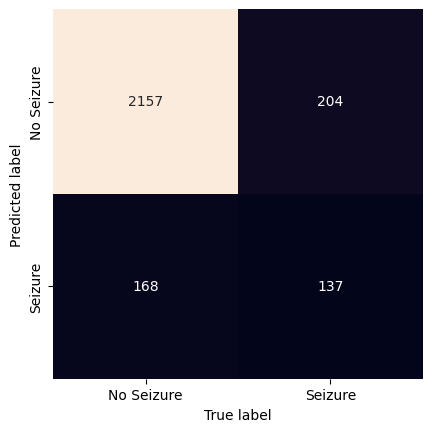

In [1265]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [1266]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2325
         1.0       0.45      0.40      0.42       341

    accuracy                           0.86      2666
   macro avg       0.68      0.66      0.67      2666
weighted avg       0.85      0.86      0.86      2666



Text(0, 0.5, 'Predictions')

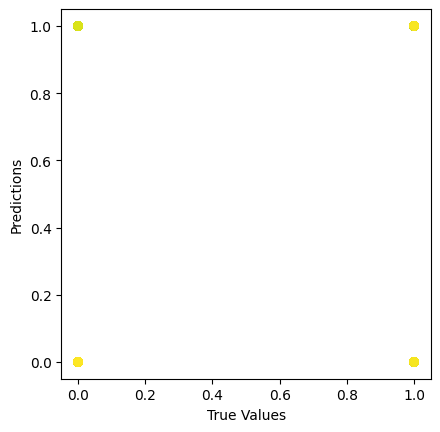

In [1160]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [43]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [44]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [45]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [46]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [47]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(72, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
X_train.shape

(1519, 30, 62)

In [49]:
y_train.shape

(1519,)

In [50]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_data=(X_val, y_val))

Epoch 1/300
16/16 [==============================] - 1s 24ms/step - loss: 0.5082 - accuracy: 0.5872 - val_loss: 0.7375 - val_accuracy: 0.4758
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.4051 - accuracy: 0.7307 - val_loss: 0.6737 - val_accuracy: 0.6210
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 0.3465 - accuracy: 0.8308 - val_loss: 0.6449 - val_accuracy: 0.6532
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2934 - accuracy: 0.8920 - val_loss: 0.6057 - val_accuracy: 0.7419
Epoch 5/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2505 - accuracy: 0.9177 - val_loss: 0.5886 - val_accuracy: 0.7419
Epoch 6/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2088 - accuracy: 0.9368 - val_loss: 0.5892 - val_accuracy: 0.7446
Epoch 7/300
16/16 [==============================] - 0s 5ms/step - loss: 0.1751 - accuracy: 0.9487 - val_loss: 0.5711 - val_accuracy: 0.7661
Epoch 8/300


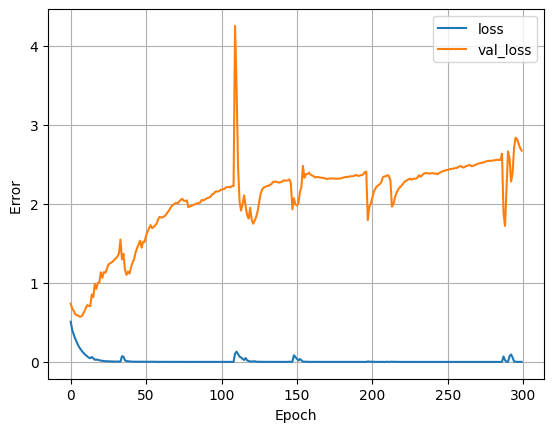

In [51]:
plot_loss(history)

In [52]:
y_pred = model.predict(X_test).flatten()
y_pred

16/16 [==============================] - 0s 2ms/step


array([4.75842608e-05, 1.16255262e-06, 1.42964209e-05, 1.90210085e-05,
       2.73882997e-05, 2.92860886e-06, 1.41938642e-07, 4.22014139e-08,
       4.28024904e-09, 2.68831908e-08, 1.78275769e-07, 1.20379880e-07,
       7.48171078e-05, 1.06487851e-05, 2.56531303e-06, 9.33447595e-08,
       1.05301194e-06, 6.78222659e-06, 3.50655841e-06, 8.14564100e-06,
       1.86041547e-08, 9.51980110e-06, 5.92688230e-05, 1.11429727e-04,
       9.93119029e-05, 3.02377826e-04, 6.70336740e-05, 1.70568048e-04,
       2.07057070e-07, 8.51139612e-06, 5.11444232e-05, 6.21638833e-07,
       4.11830915e-05, 5.29394092e-05, 8.04618758e-05, 6.71831585e-05,
       1.47229322e-04, 3.14955469e-05, 1.95127795e-05, 1.21345489e-04,
       1.43474768e-04, 1.09911780e-04, 1.18896431e-04, 1.87109472e-04,
       3.57833022e-04, 2.25989643e-04, 2.32247970e-04, 7.49437168e-05,
       1.11043410e-04, 2.76380561e-05, 2.38498415e-05, 6.33916570e-05,
       1.39067895e-04, 1.26634113e-04, 1.27313833e-04, 9.22537438e-05,
      

In [53]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 1.7415 - accuracy: 0.8286 - 29ms/epoch - 2ms/step
Model accuracy: 0.8286290168762207


In [54]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

16/16 [==============================] - 0s 1ms/step - loss: 1.7415 - accuracy: 0.8286
Loss: 1.7415165901184082
Accuracy: 0.8286290168762207
Precision: 1.0
Recall: 0.08602150537634409


(93.0, 8)

Text(0, 0.5, 'Predictions')

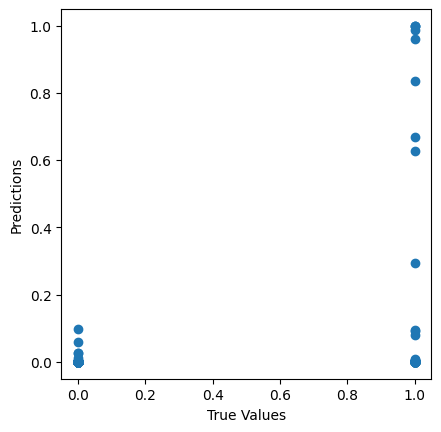

In [55]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')